# Womens Rugby Team Graph

A graph of who pairwise matches between teams. Visualising which teams frequently play each other. I also want to investigate the structure of the graph - do we detect sub-communities & if so, do they reflect features such as European or Southern tournaments.

Which teams are important - have high levels of centrality. How does this differ between 7s and 15s.

The initial plan is to use `networkx` package for visualisation, but to make it fancy I hope to utilise `pyvis`

In [170]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [14, 10]

## 7s

I'll start with rugby 7s, I'll compare the results with 15s later on. We have more data for 7s than 15s.

### Data

First I load in the data, I need to generate the adjaceny matrix, this will result in a weighted graph where the edge weights correspond to the number of matches played between the pair of teams. Further, the vertex size will correspond to the win-rate of the team represented by that vertex.

In [197]:
df7s = pd.read_csv("./data/sevens.csv")
df7s.head(5)

,row_id,date,team_1,score_1,score_2,team_2,venue,tournament,stage,t1_game_no,t2_game_no,series,margin,winner,loser,notes
0,NaN,1997-03-15,New Zealand Wild Ducks,54,0,Japan,Hong Kong,Hong Kong Sevens,Pool A,1,1,1,54.0,New Zealand Wild Ducks,Japan,NaN
1,2.0,1997-03-15,England,10,7,Australia,Hong Kong,Hong Kong Sevens,Pool A,1,1,1,3.0,England,Australia,NaN
2,3.0,1997-03-15,Canada,31,0,Netherlands,Hong Kong,Hong Kong Sevens,Pool A,1,1,1,31.0,Canada,Netherlands,NaN
3,4.0,1997-03-15,Hong Kong,12,5,Fiji,Hong Kong,Hong Kong Sevens,Pool B,1,1,1,7.0,Hong Kong,Fiji,NaN
4,5.0,1997-03-15,United States,26,5,Scotland,Hong Kong,Hong Kong Sevens,Pool B,1,1,1,21.0,United States,Scotland,NaN


In [198]:
df7s.shape

(7966, 16)

### Build the Graph

Plan for contstructing adjacency and weights

1. Groupby `team_1` and `team_2`.
2. Count number of matches.
3. Change to a dictionary and add account for reverse matches by adding away-home to home-away pairs.

Then build graph from the dictionary. I'll then normalise the weights.

In [199]:
matches = df7s[["team_1", "team_2"]].groupby(["team_1", "team_2"]).size().reset_index().rename(columns={"team_1": "home", "team_2": "away",0:"nmatches"})
matches.head(10)

,home,away,nmatches
0,Algeria,Senegal,1
1,American Samoa,Fiji,1
2,Andorra,Austria,4
3,Andorra,Belgium,1
4,Andorra,Bosnia-Herzegovina,2
5,Andorra,Bulgaria,5
6,Andorra,Croatia,1
7,Andorra,Czechia,2
8,Andorra,Germany,1
9,Andorra,Israel,3


Convert to a `dict` so that we can combine home and away matches together.

In [200]:
match_dict = {}

for i, r in matches.query('nmatches >= 5').iterrows():
	if r['away'] in match_dict.keys():
		if r['home'] in match_dict[r['away']].keys():
			match_dict[r['away']][r['home']] += r.nmatches
		else:
			match_dict[r['away']][r['home']] = r.nmatches
	elif r['home'] in match_dict.keys():
		match_dict[r['home']][r['away']] = r.nmatches
	else:
		match_dict[r['home']] = {}
		match_dict[r['home']][r['away']] = r.nmatches


Build the graph from the dictionary

In [201]:
G = nx.Graph()
for t1 in match_dict.keys():
	for t2 in match_dict[t1].keys():
		G.add_edge(t1,t2,weight=match_dict[t1][t2])

### Draw the graph

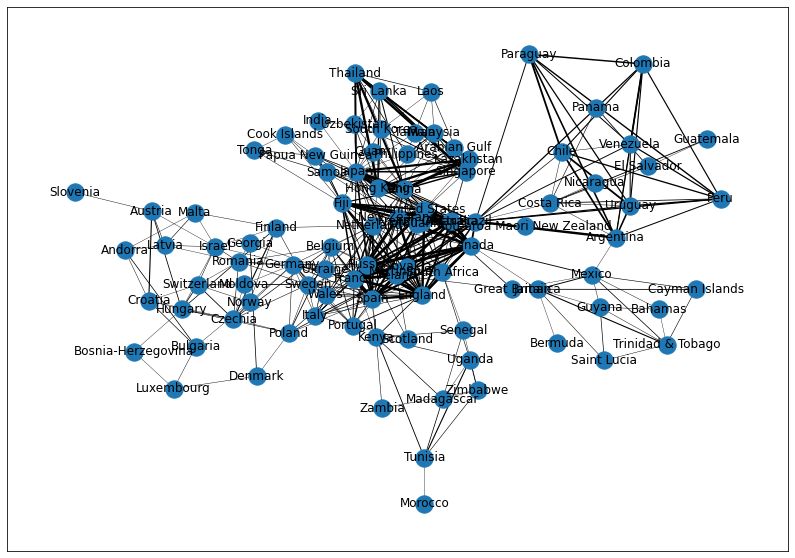

In [203]:
pos = nx.kamada_kawai_layout(G)

# Get weights (number of matches) and normalise/scale them
maxthick = max(matches['nmatches'])/3
widths = list(nx.get_edge_attributes(G, 'weight').values())
widths = np.divide(widths, maxthick)

nx.draw_networkx(G, pos=pos, width=widths)

### Early thoughts

It is clear to see that if we restrict the minimum number of matches to 5 we see emergent clusters of teams. These teams are grouped by geography - this is something I expected to see, since nearby teams are likely to play each other often.

### What next?

* I now want to make this prettier and clearer, the labels are not easy to read.
* Set vertex size relative to win rate